In [3]:
import cv2 as cv2
import argparse
import numpy as np
import os.path
from matplotlib import pyplot as plt
%matplotlib inline


def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()


In [16]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold
inpWidth = 416       #Width of network's input image
inpHeight = 416      #Height of network's input image

# Load names of classes
classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [21]:
l = net.getLayerNames()
print(l)
print(len(l))

print(net.getUnconnectedOutLayers())


['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

'\n[[200]\n [227]\n [254]]\n[200-1   227-1   254-1]   \n#[layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]\n'

In [23]:

"""
[[200]
 [227]
 [254]]
[200-1   227-1   254-1]   
#[layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]
"""

print(l[199])
print(l[226])
print(l[253])

yolo_82
yolo_94
yolo_106


In [34]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    
    print(len(boxes))
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)    
    print(indices)    
    
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

In [54]:
cap = cv2.VideoCapture('cars.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

#outs = net.forward(getOutputsNames(net))
y_82 = net.forward("yolo_82")
print(y_82.shape)

(507, 85)


(1, 3, 416, 416)


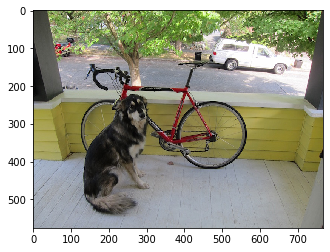

In [109]:
frame = cv2.imread("dog.jpg")
frameHeight = frame.shape[0]
frameWidth = frame.shape[1]

blob = cv2.dnn.blobFromImage(frame, 1/255,
            (inpWidth, inpHeight), [0,0,0], True, crop=False)
print(blob.shape)
net.setInput(blob)
# 82, 94, 106
yolo = net.forward("yolo_106")
    
for i in range(len(yolo)):   
    detection = yolo[i]    
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > 0.01:
        print(classes[classId])
        center_x = int(detection[0] * frameWidth)
        center_y = int(detection[1] * frameHeight)
        width = int(detection[2] * frameWidth)
        height = int(detection[3] * frameHeight)
        left = int(center_x - width / 2)
        top = int(center_y - height / 2)        
        cv2.rectangle(frame, (left, top), (left+width, top+height), (255, 178, 50), 3)
imshow("", frame)

In [91]:
cells = []
for i in range(len(yolo))     :   
    detection = yolo[i]    
    scores = detection[5:]
    classId = np.argmax(scores)
    confidence = scores[classId]    
    if confidence > 0.01:        
        cells.append(classId+1)
    else cells.append(0)
    


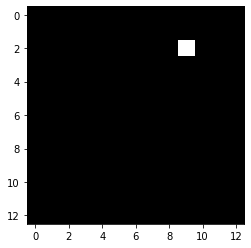

In [97]:
cells = np.array(cells)
s = int(math.sqrt(len(yolo)/3))

cells = cells.reshape(s,s,3)

img = cells[:,:,0]*30
imshow("", img)

In [ ]:
print(type(outs))
print(len(outs))

print(outs[0].shape)    
print(outs[1].shape)
print(outs[2].shape)


print(outs[0][0])  #   yolo layer 1  0번째 box

In [33]:
detection = outs[0][0]
scores = detection[5:]
print(scores)
classId = np.argmax(scores)
print(classId)
confidence = scores[classId]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
0


12
[[ 6]
 [ 5]
 [ 4]
 [ 2]
 [ 0]
 [ 3]
 [ 8]
 [10]
 [11]
 [ 1]
 [ 9]]


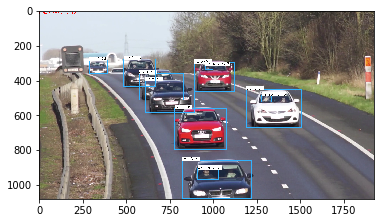

True

In [36]:
postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

imshow("", frame)
cv2.imwrite("out.jpg", frame) 

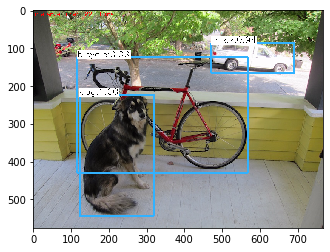

In [8]:
cv.imwrite("people.jpg", frame) 
img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
plt.imshow(img)

<img src=out.jpg>